# **SAT Linear Solver**

A lineal solver is used to determine if a logical formula is *satisfiable*, that is, if there exists a way to assign truth values (T or F) to the variables in the formula such that the entire formula is true.

### Example

Let $p \land \neg q$ be a propositional formula,

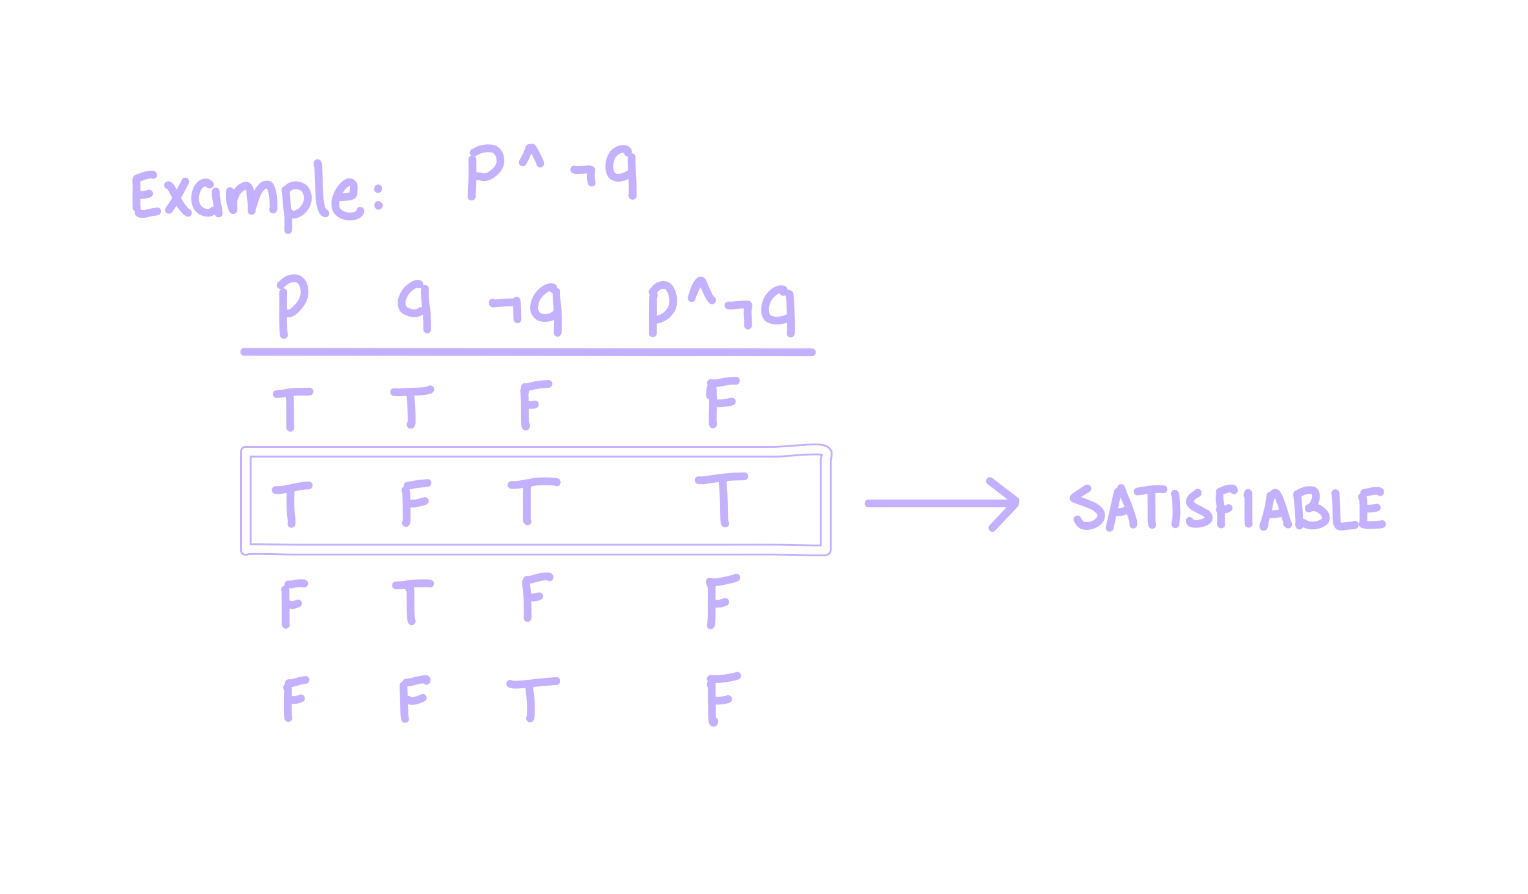

There exists a way to assign truth values to the variables in the formula such that the entire formula is true, therefore, $p \land \neg q$ is satisfiable.

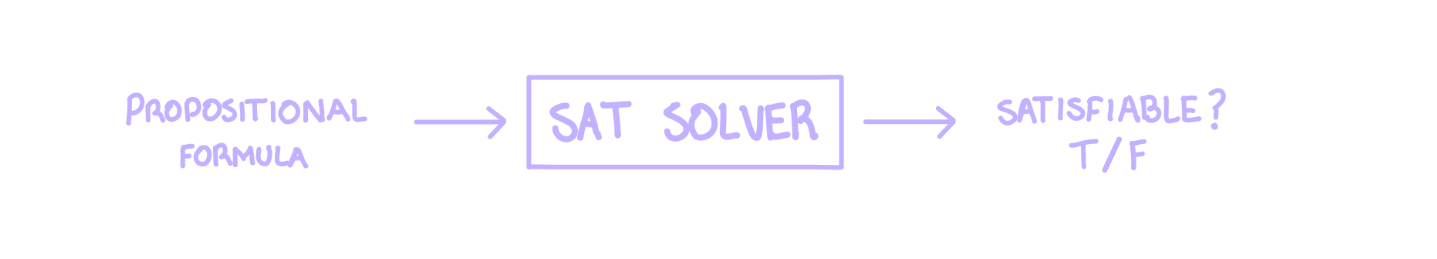

## Limitations

To be able to start with the algorithm, we will create a programming language in Racket to express logical formulas.

## Logical Language

We begin by analizing the grammar of the language we want to express and its concrete syntax,

$Formula ::= Prop \\
\hspace{1.9cm} | Neg \\
\hspace{1.9cm} | And \\
\hspace{1.9cm} | Or \\
\hspace{1.9cm} | Impl$ 

$Prop ::= "p" | "q" | "r"      \hspace{2.3cm}$   *an atomic proposition* <br>
$Neg ::= "¬" Formula           \hspace{3.1cm}$     *negation of a formula* <br>
$And ::= Formula "∧" Formula  \hspace{1.3cm}$ *conjunction of two formulas* <br>
$Or ::= Formula "∨" Formula   \hspace{1.55cm}$ *disjunction of two formulas* <br>
$Impl ::= Formula "→" Formula \hspace{1.3cm}$ *implication between two formulas* <br>

By analyzing this, we propose the following abstract syntax,

*   **l-prop (name)**
*   **l-neg (subformula)**
*   **l-and (left right)**
*   **l-or (left right)**
*   **l-impl (left right)**

<br/>

*   $l-prop : symbol \rightarrow formula$
*   $l-neg : formula \rightarrow formula$
*   $l-and : formula \times formula \rightarrow formula$
*   $l-or : formula \times formula \rightarrow formula$
*   $l-implies : formula \times formula \rightarrow formula$

### Abstract Syntax Tree (AST)

We proceed to implementing the abstract syntax tree of our language,

In [3]:
(struct formula () #:transparent)

(struct l-prop formula (name) #:transparent)         ;; p
(struct l-neg formula (subformula) #:transparent)    ;; ¬φ
(struct l-and formula (left right) #:transparent)    ;; φ ∧ φ
(struct l-or formula (left right) #:transparent)     ;; φ ∨ φ
(struct l-impl formula (left right) #:transparent)   ;; φ → φ


;;(provide
;; (contract-out
;;  [formula? (-> any/c boolean?)]
;;  [struct l-prop ([name symbol?])]
;;  [struct l-neg ([subformula formula?])]
;;  [struct l-and ([left formula?] [right formula?])]
;;  [struct l-or ([left formula?] [right formula?])]
;;  [struct l-impl ([left formula?] [right formula?])]))

Following the last example, the logical formula $p \land \neg q$ would be expressed in our language in this manner:

In [4]:
(define myformula
  (l-and
   (l-prop 'p)
   (l-neg 
    (l-prop 'q))))

myformula

(l-and (l-prop 'p) (l-neg (l-prop 'q)))

### Specification of values


Any programming language should specify the set of values it manipulates. Each language has at least two sets: expressed and denoted values. Expressed values are the possible values of expressions and denoted values are the ones bound to variables, in our case atomic propositions. 

In our language, expressed and denoted values are the same: boolean values.

#### Expressed values

We define the expressed values of our Logical language and a function to convert from expressed value to a Racket boolean.

In [5]:
(struct expressed () #:transparent)
(struct bool-expressed expressed (val) #:transparent)

(define (expressed->bool val)
  (match val
    [(bool-expressed val) val]
    ;[else
     ;(error 'expressed->bool "Not a bool: ~a" val)]
       ))

;;(provide
;; (contract-out
;;  [expressed? (-> any/c boolean?)]
;;  [struct bool-expressed ([val boolean?])]
;;  [expressed->bool  (-> expressed? boolean?)]))

#### Denoted values

We define the denoted values, the ones bound to an atomic proposition, and a function to convert from denoted value to a Racket boolean.

In [6]:
(struct denoted () #:transparent)
(struct bool-denoted denoted (val) #:transparent)

(define (denoted->bool val)
  (match val
    [(bool-denoted val) val]
    ;;[else
     ;;(error 'denoted->bool "Not a bool: ~a" val)]
        ))

;;(provide
;; (contract-out
;;  [denoted? (-> any/c boolean?)]
;;  [struct bool-denoted ([val boolean?])]
;;  [denoted->bool  (-> denoted? boolean?)]))

### Environments

To obtain the boolean values associated to atomic propositions we implement structures for environments in our language. An environment is a function whose domain is a finite set of variables and whose range is the denoted values.

In [7]:
(struct environment () #:transparent)

(struct empty-env environment () #:transparent)
(struct extend-env environment (var val parent) #:transparent)

(define (apply-env env var)
  (match env
    [(empty-env)
     (error "Empty-env reached")]
    [(extend-env (== var) val parent)
     (bool-denoted val)]
    [(extend-env bar val parent)
     (apply-env parent var)]))

;;(provide
;;  (contract-out
;;    [environment? (-> any/c boolean?)]
;;    [struct empty-env ()]
;;    [struct extend-env ([var symbol?] [val boolean?] [parent environment?])]
;;    [apply-env (-> environment? symbol? denoted?)]))


For example, if we wanted to associate a boolean value to an atomic proposition we would do the following

In [8]:
(extend-env 'p #t (empty-env))

(extend-env 'p #t (empty-env))

### Interpreter

We will define a function called *value-of* thet will look at an expression of our language, determine what kind of expression it is and return the appropiate value. In our case, value of will evaluate our logical formulas and return an expressed boolean value.

In [1]:
(define (value-of formula env)
  (match formula
    [(l-prop p)
     (bool-expressed
       (denoted->bool
         (apply-env env p)))]
    [(l-neg p)
     (bool-expressed
       (not (expressed->bool
              (value-of p env))))]
    [(l-and left right)
       (bool-expressed
         (and (expressed->bool (value-of left env))
            (expressed->bool (value-of right env))))]
    [(l-or left right)
       (bool-expressed
         (or (expressed->bool (value-of left env))
            (expressed->bool (value-of right env))))]
    [(l-impl left right)
       (bool-expressed
         (implies (expressed->bool (value-of left env))
                  (expressed->bool (value-of right env))))]))

## SAT Solver

Now that we have implemented a language to express logical formulas, we can begin with the algorithm of the SAT Linear Solver.

### 1. Formula Transformation

First, we start with the transformation of the logical formula.

Let the grammar for logical formulas be,

$\varphi ::= p \; | \; (\neg \varphi) \; | \; (\varphi \land \varphi) \; | \; (\varphi \lor \varphi) \; | \; (\varphi \rightarrow \varphi)$

We will translate them into the adequate grammar,

$\varphi ::= p \; | \; (\neg \varphi) \; | \; (\varphi \land \varphi)$



Converting them to a simpler form with inductively defined translations such as that they are semantically equivalent and have the same propositional atoms.

$T(p) = p$

$T(\varphi_1 \land \varphi_2) = T(\varphi_1) \land T(\varphi_2)$

$T(\varphi_1 \rightarrow \varphi_2) = \neg (T(\varphi_1) \land \neg T(\varphi_2))$

$T(\neg \varphi) = \neg T(\varphi)$

$T(\varphi_1 \lor \varphi_2) = \neg (\neg T(\varphi_1) \land \neg T(\varphi_2))$

We will define a function called *transform* that performs this step using the defined translations mentioned above.

In [13]:
(define (transform φ)
  (match φ
    [(l-prop prop)  ;;𝑇(𝑝)=𝑝
     prop]
    [(l-neg sub)  ;; 𝑇(¬𝜑)=¬𝑇(𝜑)
     (l-neg (transform sub))] 
    [(l-and left right)  ;; 𝑇(𝜑1∧𝜑2)=𝑇(𝜑1)∧𝑇(𝜑2)
     (l-and (transform left) (transform right))] 
    [(l-or left right) 𝑇(𝜑1∨𝜑2)=¬(¬𝑇(𝜑1)∧¬𝑇(𝜑2))  ;; 𝑇(𝜑1∨𝜑2)=¬(¬𝑇(𝜑1)∧¬𝑇(𝜑2))
     (l-neg (l-and (l-neg (transform left)) (l-neg (transform right))))]
    [(l-impl left right)  ;;𝑇(𝜑1→𝜑2)=¬(𝑇(𝜑1)∧¬𝑇(𝜑2))
     (l-neg (l-and (transform left) (l-neg (transform right))))]))

Let's test our function with an example. Let $p \land \neg (q \lor \neg p)$ be a logical formula. By following the method of the translations we would get the formula $p \land \neg \neg (\neg q \land \neg \neg p)$ , which is semantically equivalent.

We construct our initial formula

In [10]:
(define formula
  (l-and
   (l-prop 'p)
   (l-neg
    (l-or
     (l-prop 'q)
     (l-neg (l-prop 'p))))))

formula

(l-and (l-prop 'p) (l-neg (l-or (l-prop 'q) (l-neg (l-prop 'p)))))

We call our function *transform* and it returns the formula $p \land \neg \neg (\neg q \land \neg \neg p)$

In [14]:
(transform formula)

match: undefined;
 cannot reference an identifier before its definition
  in module: top-level
  context...:
   body of top-level
   eval:1:0: transform


In [ ]:
###